In [1]:
import numpy as np
import scipy

import torch
from torch.utils.data import DataLoader

import librosa
from hyperparameters import *

from custom_datasets import MelCelebDataset
from preprocessing import melspectrogram

from utils import show, random_crop
import os

from IPython.display import Audio
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from VGGish import vggish

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import warnings


warnings.filterwarnings('ignore')
sns.set()

In [3]:
data = MelCelebDataset(MEL_DATA_PATH, 'train', user_regexp='00(0|1|2|3|4|5|6|7|8|9)')
test_data = MelCelebDataset(MEL_DATA_PATH, 'test', user_regexp='00(0|1|2|3|4|5|6|7|8|9)')
len(data), len(test_data)

(1197, 242)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = vggish(include_classifier=False, pretrained=True).to(device)
net.eval()

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [14]:
from collections import defaultdict
from sklearn.manifold import TSNE

data_loader = DataLoader(data, batch_size=16, num_workers=16)

X_raw = []
y_raw = []
for i, (X, y) in enumerate(tqdm(data_loader)):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        embeddings = net(X).view(len(X), -1)
        for j in range(len(y)):
            X_raw.append(embeddings[j].cpu().numpy())
            y_raw.append(int(y[j].item()))

del X, y

X_raw = np.stack(X_raw)
y_raw = np.array(y_raw, dtype=int)

In [15]:
test_data_loader = DataLoader(test_data, batch_size=16, num_workers=16)

X_test = []
y_test = []

for i, (X, y) in enumerate(tqdm(test_data_loader)):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        embeddings = net(X).view(len(X), -1)
        for j in range(len(y)):
            X_test.append(embeddings[j].cpu().numpy())
            y_test.append(int(y[j].item()))

del X, y

X_test = np.stack(X_test)
y_test = np.array(y_test, dtype=int)

In [16]:
X_embedded = PCA(n_components=2).fit_transform(X_raw)

In [17]:
X_embedded = TSNE(n_components=2).fit_transform(X_raw)

In [18]:
X_embedded

array([[ 30.86466  ,  -3.465319 ],
       [ 13.161835 ,  16.924156 ],
       [ 26.290863 ,  -3.6919312],
       ...,
       [-13.070193 , -51.857487 ],
       [-16.696487 ,  24.353016 ],
       [-10.64731  ,  39.487034 ]], dtype=float32)

In [19]:
y_raw.shape, X_embedded.shape

((1197,), (1197, 2))

No handles with labels found to put in legend.


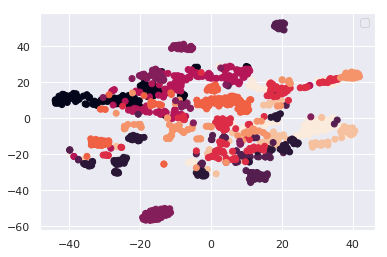

In [20]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_raw)
plt.legend()

In [25]:
from sklearn.ensemble import GradientBoostingClassifier


gdb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05)
gdb.fit(X_raw, y_raw)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [26]:
accuracy_score(gdb.predict(X_test), y_test)

0.7066115702479339

(array([18., 12., 44., 12., 17., 43.,  1., 37., 58.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 9 Patch objects>)

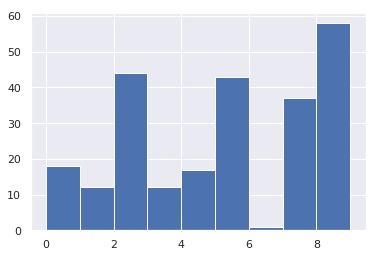

In [27]:
plt.hist(y_test, bins=y_test.max())